In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as matCol
from matplotlib.colors import ListedColormap
import os
import sys
import h5py
import time
%matplotlib qt

import warnings
warnings.filterwarnings("ignore")

#calculate fields to plot
home = 'R:/satellite_data/viirs_data/noaa20/'
# hf_composite_database = h5py.File(home+'databases/composite_database.h5','a')


with h5py.File(home+'databases/VIIRS_burn_Scar_database.h5','r') as hf_database,\
     h5py.File(home+'databases/daily_DLCF_composites_2021_west_CONUS_all_days.h5','a') as hf_daily_composites:
    
    timestamps = list(hf_database.keys())
    dataset_names = list(hf_database[timestamps[0]].keys())
    
    timestamp_min = timestamps[0]

    #stack composites here, where latest pixel overwrites all other
    #the oldest pixel should be no more than n days old (start w/8 days)
    #note a granbule does not eqaul a day, i.e. there is over lap, so use
    #time and day to decide which granule is newer in order to overwrite.
    #empty/ non valid pixels should be auto overwritten, i.e. np.nan or x<=-997
    #work backwords from newest
    #once it works try again but cloud and water clear with -998, -997 repectively
    base_image_shape           = (3604, 2354, 3)
    composite_burn_scar_RGB    = np.empty(base_image_shape)
    composite_burn_scar_RGB[:] = np.nan
    
    start, end = 0, -1#*n_days
    for i, timestamp in enumerate(timestamps[start:end]):
        dataset_dict = {}
        for dataset_name in dataset_names:
            dataset_dict[dataset_name] = hf_database[timestamp+'/'+dataset_name][:]

        r_row_idx    = dataset_dict['regrid_row_idx']
#         if np.count_nonzero(r_row_idx == -999)/len(r_row_idx.flatten()) < 0.85:
#             pass
#         else:
#             print(i, 'pass')
#             continue
        r_col_idx    = dataset_dict['regrid_col_idx']
        fill_val_idx = dataset_dict['fill_val_idx']

        # NBR           = dataset_dict['NBR'          ][r_row_idx, r_col_idx]
        # BRF_RGB       = dataset_dict['BRF_RGB'      ][r_row_idx, r_col_idx]
        cldmsk          = dataset_dict['cldmsk'       ][r_row_idx, r_col_idx]
        burn_scar_RGB   = dataset_dict['burn_scar_RGB'][r_row_idx, r_col_idx]
        land_water_mask = dataset_dict['land_water_mask'][r_row_idx, r_col_idx]
        # lat_regrid    = dataset_dict['lat'][r_row_idx, r_col_idx]
        # lon_regrid    = dataset_dict['lon'][r_row_idx, r_col_idx]
        # R_M7, R_M11 = burn_scar_RGB[:,:,1], burn_scar_RGB[:,:,0]
        # burn_scar_composite = get_burn_scar_composite(R_M7, R_M11, geotiff=False)


        # NBR[fill_val_idx[0], fill_val_idx[1]]           = np.nan
        # BRF_RGB[fill_val_idx[0], fill_val_idx[1]]       = np.nan
        cldmsk[fill_val_idx[0], fill_val_idx[1]]        = np.nan
        burn_scar_RGB[fill_val_idx[0], fill_val_idx[1],:] = np.nan
        # lat_regrid[fill_val_idx[0], fill_val_idx[1]]    = np.nan
        # lon_regrid[fill_val_idx[0], fill_val_idx[1]]    = np.nan

        # NBR[NBR<=-997]           = np.nan
        # BRF_RGB[BRF_RGB<=-997]       = np.nan
        # cldmsk[cldmsk<=-997]        = np.nan
        burn_scar_RGB[burn_scar_RGB==-999] = np.nan

        #cloud and water clear
        burn_scar_RGB[cldmsk < 2] = np.nan #noise from probably clear, may mask it out
        #the probably cloudy is important to keep other wise lose alot to smoke maybe
        burn_scar_RGB[land_water_mask == 0] = np.nan #just take out water (from cloud mask file)

        #combine data by populating nan with cloud free water free data from latest granule
        #where it's empty on composite grid
        unpopulated_composite_idx = np.where(np.isnan(composite_burn_scar_RGB))
        #where the grid is empty on the current working granule
        unpopulated_current_idx   = np.where(np.isnan(burn_scar_RGB))
#         #where the grid is valid on the current working granule
#         unpopulated_current_idx   = np.where(~np.isnan(burn_scar_RGB))
        #make a copy of the composite to restore the original where current working granule had no data
        temp_composite            = np.copy(composite_burn_scar_RGB)
#         #fill in empty area with data form current working granule
#         composite_burn_scar_RGB[unpopulated_composite_idx[0], unpopulated_composite_idx[1],:] = \
#                              burn_scar_RGB[unpopulated_composite_idx[0], unpopulated_composite_idx[1],:]
        composite_burn_scar_RGB = np.copy(burn_scar_RGB)

        #restore composite pixels overwritten by nan on the current working granule
        composite_burn_scar_RGB[unpopulated_current_idx[0], unpopulated_current_idx[1], :] = \
                                        temp_composite[unpopulated_current_idx[0], unpopulated_current_idx[1], :]
        print('{:03d}/604 {} composite updated'.format(i, timestamp))
        
        #save composite when next granule is from next day (granules are in chronilogical order)
        if int(timestamps[i+1][4:7]) > int(timestamps[i][4:7]):
            #make group with day of compsite
            hf_daily_composites.create_dataset(timestamps[i][-10:], data=composite_burn_scar_RGB, compression='gzip')
            print('saved daily composite {} *********************************'.format(timestamps[i][-10:]))
#         if i%64==0:
#             plt.figure(figsize=(10,15))
#             plt.imshow(composite_burn_scar_RGB)
#             plt.draw()
#             print('plotting {:03d}/64 {}'.format(i, timestamp))
                


000/604 2021161.1836_06.10.2021 composite updated
001/604 2021161.1842_06.10.2021 composite updated
002/604 2021161.2018_06.10.2021 composite updated
003/604 2021161.2024_06.10.2021 composite updated
004/604 2021161.2200_06.10.2021 composite updated
005/604 2021161.2206_06.10.2021 composite updated
saved daily composite 06.10.2021 *********************************
006/604 2021162.0830_06.11.2021 composite updated
007/604 2021162.1012_06.11.2021 composite updated
008/604 2021162.1154_06.11.2021 composite updated
009/604 2021162.1818_06.11.2021 composite updated
010/604 2021162.1824_06.11.2021 composite updated
011/604 2021162.1954_06.11.2021 composite updated
012/604 2021162.2000_06.11.2021 composite updated
013/604 2021162.2006_06.11.2021 composite updated
014/604 2021162.2136_06.11.2021 composite updated
015/604 2021162.2142_06.11.2021 composite updated
saved daily composite 06.11.2021 *********************************
016/604 2021163.0812_06.12.2021 composite updated
017/604 2021163.

142/604 2021179.0812_06.28.2021 composite updated
143/604 2021179.0954_06.28.2021 composite updated
144/604 2021179.1136_06.28.2021 composite updated
145/604 2021179.1936_06.28.2021 composite updated
146/604 2021179.1942_06.28.2021 composite updated
147/604 2021179.2118_06.28.2021 composite updated
148/604 2021179.2124_06.28.2021 composite updated
saved daily composite 06.28.2021 *********************************
149/604 2021180.0754_06.29.2021 composite updated
150/604 2021180.0936_06.29.2021 composite updated
151/604 2021180.1118_06.29.2021 composite updated
152/604 2021180.1918_06.29.2021 composite updated
153/604 2021180.1924_06.29.2021 composite updated
154/604 2021180.2100_06.29.2021 composite updated
155/604 2021180.2106_06.29.2021 composite updated
saved daily composite 06.29.2021 *********************************
156/604 2021181.0736_06.30.2021 composite updated
157/604 2021181.0918_06.30.2021 composite updated
158/604 2021181.1100_06.30.2021 composite updated
159/604 2021181.

282/604 2021197.1906_07.16.2021 composite updated
283/604 2021197.2042_07.16.2021 composite updated
284/604 2021197.2048_07.16.2021 composite updated
285/604 2021197.2224_07.16.2021 composite updated
286/604 2021197.2230_07.16.2021 composite updated
saved daily composite 07.16.2021 *********************************
287/604 2021198.1842_07.17.2021 composite updated
288/604 2021198.1848_07.17.2021 composite updated
289/604 2021198.2024_07.17.2021 composite updated
290/604 2021198.2030_07.17.2021 composite updated
291/604 2021198.2206_07.17.2021 composite updated
292/604 2021198.2212_07.17.2021 composite updated
saved daily composite 07.17.2021 *********************************
293/604 2021199.1018_07.18.2021 composite updated
294/604 2021199.1200_07.18.2021 composite updated
295/604 2021199.1824_07.18.2021 composite updated
296/604 2021199.1830_07.18.2021 composite updated
297/604 2021199.2006_07.18.2021 composite updated
298/604 2021199.2012_07.18.2021 composite updated
299/604 2021199.

421/604 2021216.1000_08.04.2021 composite updated
422/604 2021216.1142_08.04.2021 composite updated
423/604 2021216.1812_08.04.2021 composite updated
424/604 2021216.1942_08.04.2021 composite updated
425/604 2021216.1948_08.04.2021 composite updated
426/604 2021216.2124_08.04.2021 composite updated
427/604 2021216.2130_08.04.2021 composite updated
saved daily composite 08.04.2021 *********************************
428/604 2021217.0800_08.05.2021 composite updated
429/604 2021217.0942_08.05.2021 composite updated
430/604 2021217.1124_08.05.2021 composite updated
431/604 2021217.1924_08.05.2021 composite updated
432/604 2021217.1930_08.05.2021 composite updated
433/604 2021217.2106_08.05.2021 composite updated
434/604 2021217.2112_08.05.2021 composite updated
saved daily composite 08.05.2021 *********************************
435/604 2021218.1906_08.06.2021 composite updated
436/604 2021218.1912_08.06.2021 composite updated
437/604 2021218.2048_08.06.2021 composite updated
438/604 2021218.

559/604 2021236.2200_08.24.2021 composite updated
saved daily composite 08.24.2021 *********************************
560/604 2021237.0824_08.25.2021 composite updated
561/604 2021237.1006_08.25.2021 composite updated
562/604 2021237.1818_08.25.2021 composite updated
563/604 2021237.1948_08.25.2021 composite updated
564/604 2021237.1954_08.25.2021 composite updated
565/604 2021237.2130_08.25.2021 composite updated
566/604 2021237.2136_08.25.2021 composite updated
saved daily composite 08.25.2021 *********************************
567/604 2021238.1930_08.26.2021 composite updated
568/604 2021238.1936_08.26.2021 composite updated
569/604 2021238.2112_08.26.2021 composite updated
570/604 2021238.2118_08.26.2021 composite updated
saved daily composite 08.26.2021 *********************************
571/604 2021239.1912_08.27.2021 composite updated
572/604 2021239.1918_08.27.2021 composite updated
573/604 2021239.2054_08.27.2021 composite updated
574/604 2021239.2100_08.27.2021 composite updated

In [76]:
arr = np.full((3,3), True)
arr[0,0]=False
print(arr)
print(~arr)


[[False  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True False False]
 [False False False]
 [False False False]]


ModuleNotFoundError: No module named 'cv2'

In [75]:
from PIL import Image
import matplotlib.pyplot as plt

with h5py.File(home+'databases/daily_DLCF_composites_2021_west_CONUS_all_days.h5','r') as hf_daily_composites:
    image_list = list(hf_daily_composites.keys())
    gif = []
    images = []#images, just convert it into PIL.Image obj
    for image_name in image_list:
        print(image_name)
        image = 2*hf_daily_composites[image_name][:]
        image[np.isnan(image)] = 0
#         image*=255
        for i in range(3):
            image[:,:,i] /= np.nanmax(image[:,:,i])
        
#         break
#         plt.imshow((image*255).astype(np.uint8))
        gif.append(Image.fromarray((image*255*1.5).astype(np.uint8)).copy())
#         plt.imshow(gif[0])
#         break
        
    gif[0].save(home+'databases/temp_result_brightened.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)

06.10.2021
06.11.2021
06.12.2021
06.13.2021
06.14.2021
06.15.2021
06.16.2021
06.17.2021
06.18.2021
06.19.2021
06.20.2021
06.21.2021
06.22.2021
06.23.2021
06.24.2021
06.25.2021
06.26.2021
06.27.2021
06.28.2021
06.29.2021
06.30.2021
07.01.2021
07.02.2021
07.03.2021
07.04.2021
07.05.2021
07.06.2021
07.07.2021
07.08.2021
07.09.2021
07.10.2021
07.11.2021
07.12.2021
07.13.2021
07.14.2021
07.15.2021
07.16.2021
07.17.2021
07.18.2021
07.19.2021
07.20.2021
07.21.2021
07.22.2021
07.23.2021
07.24.2021
07.25.2021
07.26.2021
07.27.2021
07.28.2021
07.29.2021
07.30.2021
07.31.2021
08.01.2021
08.02.2021
08.03.2021
08.04.2021
08.05.2021
08.06.2021
08.07.2021
08.08.2021
08.09.2021
08.10.2021
08.11.2021
08.12.2021
08.13.2021
08.14.2021
08.15.2021
08.16.2021
08.17.2021
08.18.2021
08.19.2021
08.20.2021
08.21.2021
08.22.2021
08.23.2021
08.24.2021
08.25.2021
08.26.2021
08.27.2021
08.28.2021
08.29.2021
08.30.2021
08.31.2021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


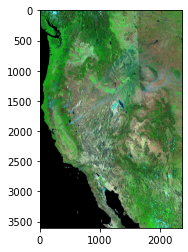

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from matplotlib import animation
import h5py
import numpy as np

home = 'R:/satellite_data/viirs_data/noaa20/'

with h5py.File(home+'databases/daily_DLCF_composites_2021_west_CONUS_all_days.h5','r') as hf_daily_composites:
    image_list = list(hf_daily_composites.keys())
    snapshots = []
    fig, ax = plt.subplots()
    for image_name in image_list:
#         print(image_name)
        image = 2*hf_daily_composites[image_name][:]
        image[np.isnan(image)] = 0
#         snapshots.append(image)
        snapshots.append([ax.imshow(image)])
    
    ani = animation.ArtistAnimation(fig, snapshots, interval=700, blit=False,
                                    repeat=True)
    ani.save(home+'databases/test_anim.mp4')
        
# fps = 1
# nSeconds = len(snapshots)

# # First set up the figure, the axis, and the plot element we want to animate
# fig = plt.figure( figsize=(10,15) )

# a = snapshots[0]
# im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

# def animate_func(i):
#     if i % fps == 0:
#         print( '.', end ='' )

#     im.set_array(snapshots[i])
#     return [im]

# anim = FuncAnimation(
#                                fig,
#                                animate_func,
#                                frames = nSeconds * fps,
#                                interval = 1000 / fps, # in ms
#                                )

# # anim.save(home+'databases/test_anim.mp4', writer=animation.FFMpegWriter())

# # setting up wrtiers object
# Writer = writers['ffmpeg']
# writer = Writer(fps=1, metadata={'artist': 'Javier Villegas Bravo'}, bitrate=128000)

# anim.save(home+'databases/test_anim.mp4', writer)

In [ ]:
#         #check if 8 days has been recorded first, which is 64 files
#         if i>=64:
#             #then record the composite as it updates every day, which is 8 files into the database
#             if i%8==0:
#                 R_M7, R_M11 = np.copy(composite_burn_scar_RGB[:,:,1]), np.copy(composite_burn_scar_RGB[:,:,0])
#                 NBR_composite = (R_M11-R_M7)/(R_M11+R_M7)

#                 bad_val = np.nan
#         #         R_M11_ = ndimage.gaussian_filter(R_M11, sigma=1)
#                 R_M11_ = R_M11
#                 R_M11_[R_M7  > 0.2]  = bad_val #for clear no smoke only
#                 R_M11_[R_M7 < 0.0281] = bad_val
#                 R_M11_[R_M11 < 0.06]  = bad_val
#                 # R_M11[R_M11 > 0.3]   = bad_val

#                 composite_burn_scar_thresh = R_M11_
#                 NBR_composite[np.isnan(composite_burn_scar_thresh)] = np.nan

#                 #############################################################
#                 #plot
#                 %matplotlib qt
#                 rows, cols, colors = base_image_shape 
#                 X,Y = np.meshgrid(np.arange(cols), np.arange(rows))
#                 plt.style.use('dark_background')
#                 f, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(24,13))
#                 # im = plt.imshow(composite_burn_scar_RGB[:,:,1], cmap='jet',vmin=0.0281, vmax=0.1346)
#                 # im.cmap.set_over('grey')
#                 # im.cmap.set_under('cyan')
#                 im = ax[0].imshow(composite_burn_scar_RGB)
#                 ax[1].imshow(composite_burn_scar_RGB)
#                 # ax[1].imshow(composite_burn_scar_thresh, cmap='jet', vmax=0.22)
#                 ax[1].imshow(NBR_composite, cmap='jet', vmax=0.25)
#                 # ax[1].contourf(X,Y,composite_burn_scar_thresh, levels=40, cmap='jet')
#                 ax[2].imshow(2*composite_burn_scar_RGB)
#                 for a in ax.flat:
#                     a.set_xticks([])
#                     a.set_yticks([])
#                 f.suptitle(timestamps[i][-10:], fontsize=24)
#                 plt.tight_layout()
# #                 plt.savefig(home+'databases/'+timestamps[i]+'.jpg')
#                 plt.show()
#                 try:
#                     hf_composite_database.create_dataset(timestamp, data=composite_burn_scar_RGB, compression='gzip')
#                     print('{:03d}/604 {} composite recorded'.format(i, timestamp))
#                 except:
#                     hf_composite_database[timestamp][:] = composite_burn_scar_RGB
#                     print('{:03d}/604 {} composite updated'.format(i, timestamp))
                

# hf_composite_database.close()

In [ ]:
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib qt

with h5py.File(home+'databases/VIIRS_burn_Scar_database.h5','r') as hf_composite_database:
    timestamps = list(hf_composite_database.keys())#[-30:-1]
    t_temp = [int(x[8:12]) for x in timestamps]
    print(np.sort(t_temp))
    plt.hist(t_temp)
    plt.show()
#     for i in range(len(timestamps)):
#         pass
#         composite_burn_scar_RGB = hf_composite_database[timestamps[i]][:]
        

#     R_M7, R_M11 = np.copy(composite_burn_scar_RGB[:,:,1]), np.copy(composite_burn_scar_RGB[:,:,0])
#     NBR_composite = (R_M11-R_M7)/(R_M11+R_M7)

#     bad_val = 0
# #         R_M11_ = ndimage.gaussian_filter(R_M11, sigma=1)
#     R_M11[R_M7  > 0.1346] = bad_val #for clear no smoke only
#     R_M11[R_M7  < 0.0281] = bad_val

#     composite_burn_scar_thresh = R_M11
#     composite_burn_scar_thresh = ndimage.gaussian_filter(composite_burn_scar_thresh, sigma=3)
#     composite_burn_scar_thresh[composite_burn_scar_thresh<0.01]=np.nan

#     NBR_composite[np.isnan(composite_burn_scar_thresh)] = np.nan
#     NBR_composite[composite_burn_scar_thresh<=0] = np.nan

#     #############################################################
#     #plot
#     %matplotlib qt
#     rows, cols, colors = base_image_shape 
#     X,Y = np.meshgrid(np.arange(cols), np.arange(rows))
#     plt.style.use('dark_background')
#     f, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(24,13))
#     # im = plt.imshow(composite_burn_scar_RGB[:,:,1], cmap='jet',vmin=0.0281, vmax=0.1346)
#     # im.cmap.set_over('grey')
#     # im.cmap.set_under('cyan')
#     im = ax[0].imshow(composite_burn_scar_RGB)
#     ax[1].imshow(composite_burn_scar_RGB)
#     # ax[1].imshow(composite_burn_scar_thresh, cmap='jet', vmax=0.22)
#     ax[1].imshow(NBR_composite, cmap='gist_ncar', vmax=0.5)
#     # ax[1].contourf(X,Y,composite_burn_scar_thresh, levels=40, cmap='jet')
#     ax[2].imshow(2*composite_burn_scar_RGB)
#     for a in ax.flat:
#         a.set_xticks([])
#         a.set_yticks([])
# #     f.suptitle(timestamps[i][-10:], fontsize=24)
#     f.suptitle('09.01.2021', fontsize=24)
#     plt.tight_layout()
# #         plt.savefig(home+'databases/'+timestamps[i]+'.jpg')
#     plt.show()
# #         break
#         # plt.close()

In [ ]:
%matplotlib qt
rows, cols, colors = base_image_shape 
X,Y = np.meshgrid(np.arange(cols), np.arange(rows))
plt.style.use('dark_background')
f, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(24,13))
# im = plt.imshow(composite_burn_scar_RGB[:,:,1], cmap='jet',vmin=0.0281, vmax=0.1346)
# im.cmap.set_over('grey')
# im.cmap.set_under('cyan')
im = ax[0].imshow(2*composite_burn_scar_RGB)
ax[1].imshow(composite_burn_scar_RGB)
# ax[1].imshow(composite_burn_scar_thresh, cmap='jet', vmax=0.22)
ax[1].imshow(NBR_composite, cmap='jet', vmax=0.25)
# ax[1].contourf(X,Y,composite_burn_scar_thresh, levels=40, cmap='jet')
# ax[2].imshow(2*composite_burn_scar_RGB)
for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()
# plt.close()